# Action Detection For Sign Language

In [1]:
#syntax for installing dependencies
#!pip install tensorflow opencv-python mediapipe sklearn matplotlib
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


###### Extract Key-points

In [2]:
mp_holistic = mp.solutions.holistic     # holistic model-downloading the model and leveraging it to make detections
mp_drawing = mp.solutions.drawing_utils # drawing utilities-It makes easier to actually draw the key-points on our face.

In [3]:
# function to make detection
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert color space from BGR to RGB
    image.flags.writeable = False                  # image is no longer writeable
    results = model.process(image)                 # predictions
    image.flags.writeable = True                   # image is writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # convert color space from RGB to BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    
    # face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(255, 255, 86), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=1))
    
    # pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 86, 170), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(86, 255, 255), thickness=2, circle_radius=2)) 
    
    # left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(0, 127, 255), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))
    
    # right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))

In [5]:
cap = cv2.VideoCapture(0) # read the feed from webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():     # double-check for webcam access & loop through all frames

        # read feed/frames from webcam
        ret, frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
       
        # draw formatted landmarks
        draw_styled_landmarks(image, results)
        
        # show image to screen
        cv2.imshow('OpenCV Feed', image)

        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

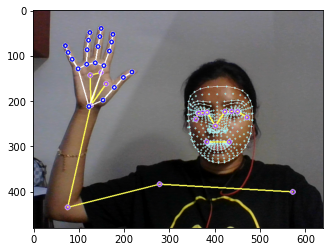

In [6]:
draw_styled_landmarks(frame, results) # apply landmarks
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # color conversion

###### Extract Key-point Values

In [7]:
results.pose_landmarks

landmark {
  x: 0.6292293667793274
  y: 0.5321872234344482
  z: -0.972146213054657
  visibility: 0.9999750852584839
}
landmark {
  x: 0.6619032025337219
  y: 0.46608856320381165
  z: -0.9146109819412231
  visibility: 0.9999399781227112
}
landmark {
  x: 0.6847172975540161
  y: 0.46553337574005127
  z: -0.9145089983940125
  visibility: 0.9999036192893982
}
landmark {
  x: 0.7059756517410278
  y: 0.4657849073410034
  z: -0.9146833419799805
  visibility: 0.9999228119850159
}
landmark {
  x: 0.6006314754486084
  y: 0.46972477436065674
  z: -0.8822412490844727
  visibility: 0.9999533295631409
}
landmark {
  x: 0.5849925875663757
  y: 0.4715854227542877
  z: -0.8815168142318726
  visibility: 0.9999403953552246
}
landmark {
  x: 0.5718687772750854
  y: 0.4747033715248108
  z: -0.8818308115005493
  visibility: 0.9999645948410034
}
landmark {
  x: 0.7381386756896973
  y: 0.4929146468639374
  z: -0.49477618932724
  visibility: 0.9999083280563354
}
landmark {
  x: 0.5617748498916626
  y: 0.501380

In [8]:
def extract_keypoints(results):
    
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
    if results.pose_landmarks else np.zeros(33*4)
        
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
    if results.face_landmarks else np.zeros(468*3)
    
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
    if results.left_hand_landmarks else np.zeros(21*3)
    
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
    if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

In [9]:
extract_keypoints(results)

array([ 0.62922937,  0.53218722, -0.97214621, ...,  0.11127197,
        0.16418104, -0.0350935 ])

In [10]:
extract_keypoints(results).shape

(1662,)

In [11]:
data_path = os.path.join('MP_Data') #path for exported data

actions = np.array(['hello', 'thanks', 'iloveyou','yes','no','please','goodbye','sorry']) #actions to be detected

no_sequences = 10 #no. of videos collected for each action

sequence_length = 10 #frame length of each video

In [12]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

###### Collect Key-point Values for Train & Test

In [14]:
cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    #NEW LOOP
    for action in actions: # loop through actions
        for sequence in range(no_sequences): # loop through sequences/videos
            for frame_no in range(sequence_length): # loop through video length 

                # read frames
                ret, frame = cap.read()

                # make detections
                image, results = mediapipe_detection(frame, holistic)

                # draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW collection wait logic
                if frame_no == 0:
                    cv2.putText(image, 'COLLECTING NOW...', (120, 200), 
                                cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                    cv2.waitKey(1500) # 1.5 seconds break
                else:
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                
                # NEW extract key-points
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_no))
                np.save(npy_path, keypoints)
                
                # break gracefully if hit 'q' on keyboard
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames

###### Pre-process Data and Create Lables & Features

In [53]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [54]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0,
 'thanks': 1,
 'iloveyou': 2,
 'yes': 3,
 'no': 4,
 'please': 5,
 'goodbye': 6,
 'sorry': 7}

In [55]:
sequences, labels = [], [] # blank arrays
for action in actions:
    for sequence in range(no_sequences):
        window = [] # blank array
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [56]:
np.array(sequences).shape

(80, 10, 1662)

In [57]:
np.array(labels).shape

(80,)

In [58]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) # one-hot-encoding

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

 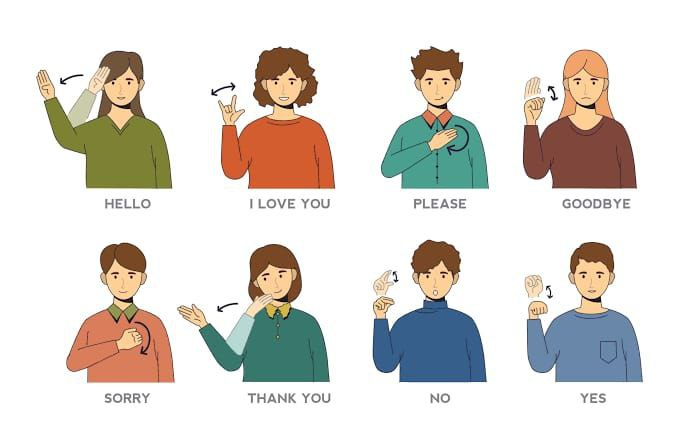